*Эксплуатационная практика Шебанова Вячеслава 15 вариант "Применение нейронных сетей для прогнозирования потребности в кадровых ресурсах"*

*Установление библиотек*

In [ ]:

%pip install numpy pandas matplotlib seaborn scikit-learn tensorflow statsmodels jupyter --quiet

print("Все библиотеки установлены!")

^C
Note: you may need to restart the kernel to use updated packages.
Все библиотеки установлены!



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\Machcreator\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


*Импорт библиотек*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Attention, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from statsmodels.tsa.seasonal import seasonal_decompose

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {'Да' if tf.config.list_physical_devices('GPU') else 'Нет'}")
print("Готово к работе!")


TensorFlow: 2.15.0
GPU: Нет
Готово к работе!


*Генерация данных (тренд, шум, сезонность, потребность)*

In [ ]:
np.random.seed(42)
dates = pd.date_range(start='2018-01-01', periods=84, freq='M')
n = len(dates)

# Тренд: рост на 3 человека в месяц
trend = 120 + 3 * np.arange(n)

# Сезонность: пик в сентябре-октябре (набор), спад в январе
seasonality = 20 * np.sin(2 * np.pi * (np.arange(n) % 12) / 12) + \
              15 * np.sin(4 * np.pi * (np.arange(n) % 12) / 12)

# Шум
noise = np.random.normal(0, 5, n)

# Итоговая потребность
demand = trend + seasonality + noise
demand = np.round(demand).astype(int)
demand = np.clip(demand, 100, None)

df = pd.DataFrame({'date': dates, 'demand': demand})
df.set_index('date', inplace=True)

print("Данные сгенерированы:")
display(df.head(10))

Данные сгенерированы:


,demand
date,
2018-01-31,122
2018-02-28,145
2018-03-31,160
2018-04-30,157
2018-05-31,135
2018-06-30,131
2018-07-31,146
2018-08-31,148
2018-09-30,137


*Анализ временных рядов с визуализацией*

Папки созданы: results/, models/, data/


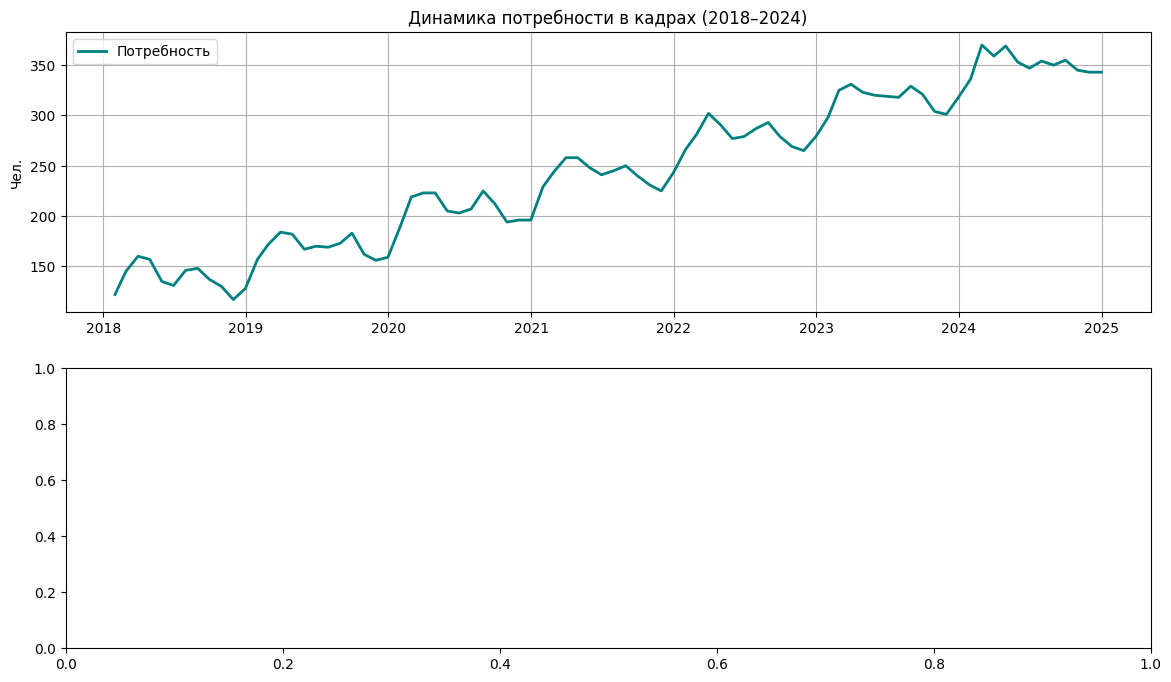

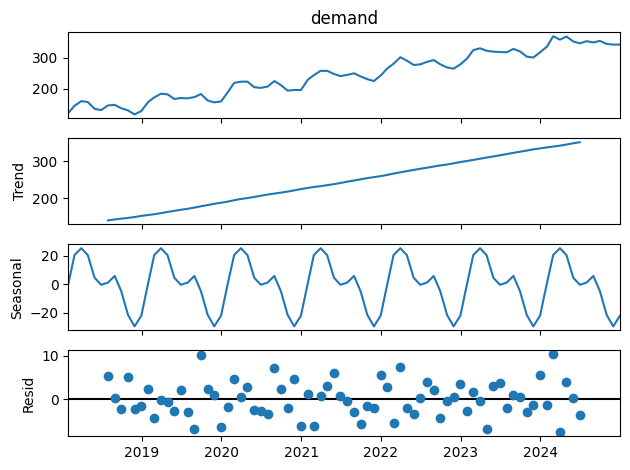

In [ ]:
import os
for folder in ['results', 'models', 'data']:
    os.makedirs(folder, exist_ok=True)
# Создаём нужные папки
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

print("Папки созданы: results/, models/, data/")

fig, ax = plt.subplots(2, 1, figsize=(14, 8))

# Полный график
ax[0].plot(df.index, df['demand'], label='Потребность', color='teal', linewidth=2)
ax[0].set_title('Динамика потребности в кадрах (2018–2024)')
ax[0].set_ylabel('Чел.')
ax[0].legend()
ax[0].grid(True)

# Декомпозиция
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df['demand'], model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.savefig('results/decomposition.png', dpi=300)
plt.show()

*Подготовка данных*

In [ ]:
def create_features(df):
    df = df.copy()
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['lag_1'] = df['demand'].shift(1)
    df['lag_12'] = df['demand'].shift(12)
    df['rolling_mean_3'] = df['demand'].rolling(3).mean()
    df['rolling_std_6'] = df['demand'].rolling(6).std()
    return df.dropna()

df_features = create_features(df)
print("Фичи добавлены:")
display(df_features.tail())

# Масштабирование
scaler_demand = MinMaxScaler()
scaler_features = StandardScaler()

target = df_features[['demand']]
features = df_features.drop('demand', axis=1)

target_scaled = scaler_demand.fit_transform(target)
features_scaled = scaler_features.fit_transform(features)

# Создание последовательностей
def create_sequences_multivariate(target, features, seq_length=12):
    X, y = [], []
    for i in range(seq_length, len(target)):
        X.append(np.hstack([target[i-seq_length:i], features[i-seq_length:i]]))
        y.append(target[i])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12
X, y = create_sequences_multivariate(target_scaled, features_scaled, SEQ_LENGTH)

# Разделение
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

Фичи добавлены:


,demand,month,quarter,year,lag_1,lag_12,rolling_mean_3,rolling_std_6
date,,,,,,,,
2024-08-31,350,8,3,2024,354.0,329.0,350.333333,7.814516
2024-09-30,355,9,3,2024,350.0,321.0,353.000000,7.607014
2024-10-31,345,10,4,2024,355.0,304.0,350.000000,4.033196
2024-11-30,343,11,4,2024,345.0,301.0,347.666667,4.857983
2024-12-31,343,12,4,2024,343.0,318.0,343.666667,5.428321


X_train: (48, 12, 8), X_test: (12, 12, 8)


*Проектирование модели с слоями внимания*

In [ ]:

def visualize_model():
    try:
        # Проверяем Graphviz
        import subprocess
        result = subprocess.run(['dot', '-V'], capture_output=True, text=True, timeout=5)
        if result.returncode != 0:
            raise Exception("Graphviz не найден в PATH")
        
        plot_model(
            model,
            to_file='results/model_architecture.png',
            show_shapes=True,
            show_layer_names=True,
            rankdir='TB',
            dpi=300
        )
        print("✅ Схема сохранена: results/model_architecture.png")
        display(Image('results/model_architecture.png'))
        
    except Exception as e:
        print(f"⚠️ Визуализация недоступна: {e}")
        print("\n📋 Используем текстовую схему:\n")
        model.summary()

visualize_model()

⚠️ Визуализация недоступна: [WinError 2] Не удается найти указанный файл

📋 Используем текстовую схему:

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 8)]           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 12, 256)           140288    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 12, 256)           0         
                                                                 
 lstm_6 (LSTM)               (None, 12, 64)            82176     
                                                                 
 attention_layer_2 (Attenti  (None, 64)                76        
 onLayer)                                                        
                    

![Визуализация модели](lstm_attention_model.png)


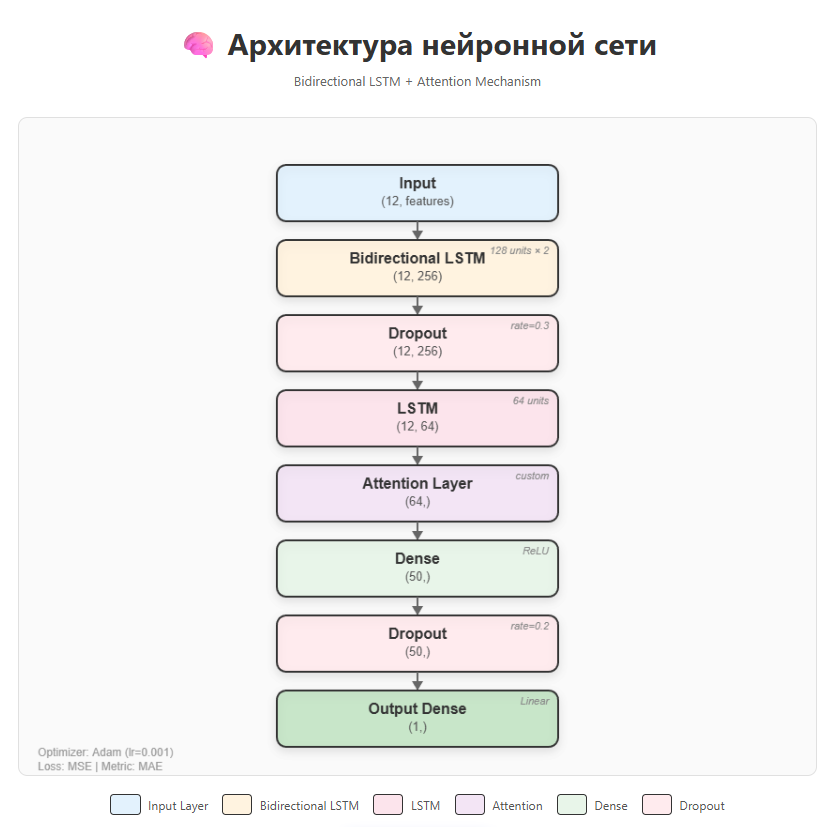

*Обучение (кросс-валидация, callbacks)*

In [14]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7),
    ModelCheckpoint('models/best_model.h5', monitor='val_loss', save_best_only=True)
]

tscv = TimeSeriesSplit(n_splits=3)
val_losses = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"\nFold {fold + 1}")
    history = model.fit(
        X_train[train_idx], y_train[train_idx],
        validation_data=(X_train[val_idx], y_train[val_idx]),
        epochs=200,
        batch_size=16,
        callbacks=callbacks,
        verbose=1
    )
    val_losses.append(min(history.history['val_loss']))

print(f"Средняя валидационная потеря: {np.mean(val_losses):.4f}")


Fold 1
Epoch 1/200


1/1 [==============================] - 7s 7s/step - loss: 0.1086 - mae: 0.3177 - val_loss: 0.1070 - val_mae: 0.3228 - lr: 0.0010
Epoch 2/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0122 - mae: 0.0999 - val_loss: 0.0550 - val_mae: 0.2279 - lr: 0.0010
Epoch 3/200
1/1 [==============================] - 0s 82ms/step - loss: 0.0122 - mae: 0.0953 - val_loss: 0.0498 - val_mae: 0.2174 - lr: 0.0010
Epoch 4/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0094 - mae: 0.0849 - val_loss: 0.0619 - val_mae: 0.2448 - lr: 0.0010
Epoch 5/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0030 - mae: 0.0400 - val_loss: 0.0715 - val_mae: 0.2644 - lr: 0.0010
Epoch 6/200
1/1 [==============================] - 0s 49ms/step - loss: 0.0025 - mae: 0.0425 - val_loss: 0.0824 - val_mae: 0.2847 - lr: 0.0010
Epoch 7/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0106 - mae: 0.0792 - val_loss: 0.0797 - val_mae: 0.2800 - lr